In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import date
# from mod_macd_utils.macd import get_macd_signal_line, get_signal_macd_crossover
# from mod_backtest_utils.backtest import Strategy, Portfolio

In [2]:
from mod_my_utils.read_write_data import *

In [3]:
folder_path = 'data/'
stock_name = 'AAPL'
index_col = 'Date'

In [4]:
stock_data = get_price_csv(folder_name=folder_path,symbol=stock_name, index_col=index_col)

stock name:  AAPL


In [5]:
data = stock_data[["Adj. Close"]].copy()
data.columns = ["price"]
data.head()

,price
Date,
2007-12-03,22.986003
2007-12-04,23.108091
2007-12-05,23.839335
2007-12-06,24.411582
2007-12-07,24.970258


### Read Data

In [3]:
symbols = ["HDFC", 'RELIANCE', 'TCS', 'HINDUNILVR', 'INFY', 'HDFC', 'BHARTIARTL', 'ITC', 'ASIANPAINT', 'NESTLEIND', 'HCLTECH', 'SBI', 'SBIN']

In [4]:
symbol = symbols[0]
data_source = "yahoo"
# MM/DD/YYYY
start_date = "1/1/2010"
end_date = "1/1/2015"
print(start_date)
print(end_date)
print(symbol)

1/1/2010
1/1/2015
HDFC


In [5]:
stock_data = get_price_yahoo(symbol=symbol, data_source=data_source, start_date= start_date, end_date= end_date )

stock name HDFC


In [6]:
data = stock_data[["Adj Close"]].copy() 
data.columns = ['price']
data.head()

,price
Date,
2010-01-04,442.267731
2010-01-05,443.772675
2010-01-06,445.906067
2010-01-07,437.604218
2010-01-08,429.980530


### MACD

In [6]:
from mod_macd_utils.macd import get_signal_macd_crossover, get_macd_signal_line

In [7]:
short_window = 80
long_window = 100
signal_window = 20

In [8]:
macd_signal_line = get_macd_signal_line(data, short_window=short_window, long_window=long_window, signal_window=signal_window)

In [9]:
signals = get_signal_macd_crossover(macd_signal_line, long_window)

<AxesSubplot:xlabel='Date'>

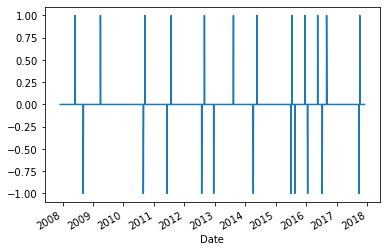

In [10]:
signals.buy_sell.plot()

### Develop portfolio

In [11]:
from mod_portfolio_utils.portfolio import get_stock_portfolio

In [12]:
portfolio = get_stock_portfolio(signals=signals)

In [13]:
portfolio.head()

,holdings_in_stock,cash,total
Date,,,
2007-12-03,0.0,100000.0,100000.0
2007-12-04,0.0,100000.0,100000.0
2007-12-05,0.0,100000.0,100000.0
2007-12-06,0.0,100000.0,100000.0
2007-12-07,0.0,100000.0,100000.0


<AxesSubplot:xlabel='Date'>

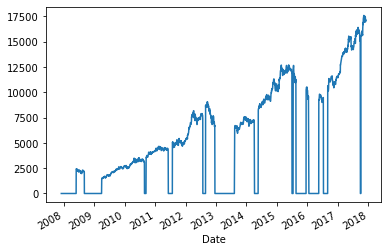

In [14]:
portfolio.holdings_in_stock.plot()

<AxesSubplot:xlabel='Date'>

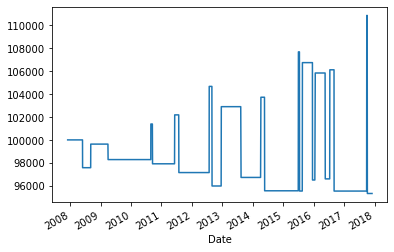

In [15]:
portfolio.cash.plot()

<AxesSubplot:xlabel='Date'>

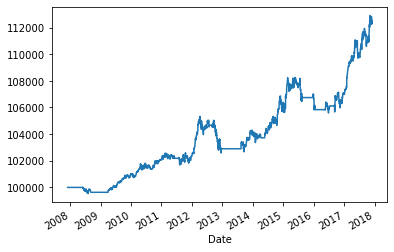

In [16]:
portfolio.total.plot()

### MA strategy and portfolio

In [17]:
from mod_backtest_utils.backtest import Strategy, Portfolio

### Strategy

In [18]:
# ma_cross.py
class MovingAverageCrossStrategy(Strategy):
    """
    Requires:
    symbol: A stock symbol on which to form a strategy
    bars: A DataFrame of bars for the above symbol
    short_window: Looback period for short moving average
    long_window: Lookback period for long movign average.
    """
    
    def __init__(self, symbol, bars, short_window= 80, long_window= 100, signal_window = 20):
        self.symbol = symbol
        self.bars = bars
        self.short_window = short_window
        self.long_window = long_window
        self.signal_window = signal_window
        
    def generate_signals(self):
        """
        Returns the DataFrame of symbols containing the signals to go long, short or hold (1, -1, 0)
        """
        signals = pd.DataFrame(index=self.bars.index)
        signals['buy_sell'] = 0.0
        signals['price'] = self.bars['price']
        
        # Create the set of short and long simple moving average over the respective periods
        signals['SMA'] = signals['price'].rolling(self.short_window, min_periods=1).mean()
        signals['LMA'] = signals['price'].rolling(self.long_window, min_periods=1).mean()
        
        # Create a signal (invested or not invested) when the short moving average cross the 
        # long moving average, but only for the period greater than the long moving average window
        signals['buy_sell'][self.long_window:] = np.where(signals['SMA'][self.long_window:]
                                                        > signals['LMA'][self.long_window:], 1.0, 0.0)
        
        # Take the difference of the signals in order to generate actual trading orders
        signals['buy_sell'] = signals['buy_sell'].diff()
        
        return signals[['price', 'buy_sell']]
        

In [19]:
symbol = 'AAPL'
macd_ma = MovingAverageCrossStrategy(symbol= symbol, bars=data)

In [20]:
macd_signals = macd_ma.generate_signals()

<AxesSubplot:xlabel='Date'>

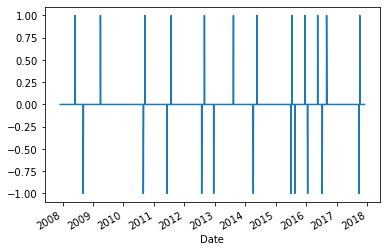

In [21]:
macd_signals.buy_sell.plot()

### Portfolio

In [22]:
# ma_cross.py

class MarketOnPricePortfolio(Portfolio):
    """
    Inherits Portfolio to create a system that purchases 100 units of a particular symbol upon a long/short signals, 
    assuming the market open price of a bar.
    Encapsulates the notion of a portfolio of positions based on a set of signals as provided by a Strategy
    
    In addition, there are zero transaction costs and cash can be immediately borrowed for shorting (no margin posting or interest
    requirements).
    
    Requires:
    symbol - A stock symbol which forms the basis of the portfolio.
    signals - A pandas DataFrame of signals (1, 0, -1) or each symbol.
    Initial_capital - the amount in cash at the start of the portfolio."""
    
    def __init__(self, symbol, signals, initial_capital=100000.0):
        self.symbol = symbol
        self.signals = signals
        self.initial_capital = float(initial_capital)
        self.positions = self.generate_positions()
        
    def generate_positions(self):
        """
        Creates a 'positions' DataFrame that simply longs or shorts 100 of the particular symbol based on the 
        forecast signals of {1, 0, -1} from the signals DataFrame."""
        positions = pd.DataFrame(index= self.signals.index).fillna(0.0)
        # Buy and sell a 100 shares based on signals and accumulate position
        positions[self.symbol] = 100 * self.signals['buy_sell'].cumsum() 
        return positions
    
    def backtest_portfolio(self):
        """
        Constructs a portfolio from the positions DataFrame by assuming the ability to trade at 
        the precise market price of each bar.
        
        Calculates the total of cash and the holding (market price of each position per bar), in order to 
        generate an equity curve (total) and a set of bar based returns ('return).
        
        Returns the portfolio object to be used elsewhere.
        """
        
        # Construct the portfolio dataframe to use the same index
        # as 'positons' and with a set of 'trading orders' in the
        # 'pos_diff' object, assumping market open prices.
        
        portfolio = pd.DataFrame(index=self.signals.index)
        # Initialize the portfolio with value owned 
        portfolio[self.symbol] = self.positions[self.symbol].multiply(self.signals['price'], axis=0)
        pos_diff = 100 * self.signals[['buy_sell']]
        # add holding to portfolio
        portfolio['holdings'] = (self.positions.multiply(self.signals['price'], axis=0)).sum(axis=1)
        # Add `cash` to portfolio
        portfolio['cash'] = self.initial_capital - (pos_diff.multiply(self.signals['price'], axis=0)).sum(axis=1).cumsum()   
        portfolio['total'] = portfolio['cash'] + portfolio['holdings']
        # return the portfolio
        return portfolio[['holdings', 'cash', 'total']]

In [23]:
portfolio_ma = MarketOnPricePortfolio(symbol=symbol, signals=signals)

In [24]:
macd_portfolio = portfolio_ma.backtest_portfolio()

<AxesSubplot:xlabel='Date'>

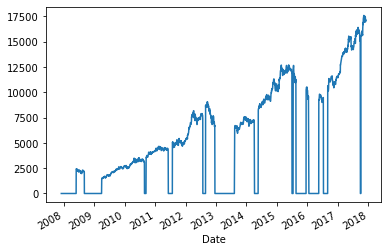

In [25]:
macd_portfolio.holdings.plot()

<AxesSubplot:xlabel='Date'>

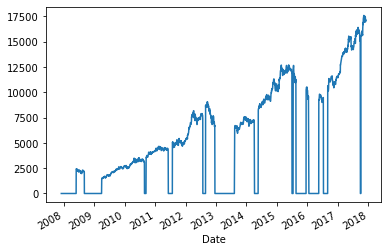

In [26]:
macd_portfolio.holdings.plot()

In [27]:
### Process

- Read data
- Get object of strategy type
- Get signal

In [28]:
bars = data

In [29]:
mac = MovingAverageCrossStrategy(symbol, bars, short_window=100, long_window=400)

In [30]:
signals = mac.generate_signals()
signals.tail(10)

,price,buy_sell
Date,,
2017-11-17,170.15,0.0
2017-11-20,169.98,0.0
2017-11-21,173.14,0.0
2017-11-22,174.96,0.0
2017-11-24,174.97,0.0
2017-11-27,174.09,0.0
2017-11-28,173.07,0.0
2017-11-29,169.48,0.0
2017-11-30,171.85,0.0


#### Generate portfolio type object

In [31]:
portfolio = MarketOnPricePortfolio(symbol, signals, initial_capital=100000.0)

In [32]:
equity_curve = portfolio.backtest_portfolio()

In [33]:
equity_curve.tail()

,holdings,cash,total
Date,,,
2017-11-27,17409.0,94932.955431,112341.955431
2017-11-28,17307.0,94932.955431,112239.955431
2017-11-29,16948.0,94932.955431,111880.955431
2017-11-30,17185.0,94932.955431,112117.955431
2017-12-01,17105.0,94932.955431,112037.955431


In [34]:
equity_curve['returns'] = equity_curve.total.pct_change()

In [35]:
equity_curve.head()

,holdings,cash,total,returns
Date,,,,
2007-12-03,0.0,100000.0,100000.0,NaN
2007-12-04,0.0,100000.0,100000.0,0.0
2007-12-05,0.0,100000.0,100000.0,0.0
2007-12-06,0.0,100000.0,100000.0,0.0
2007-12-07,0.0,100000.0,100000.0,0.0


<AxesSubplot:xlabel='Date'>

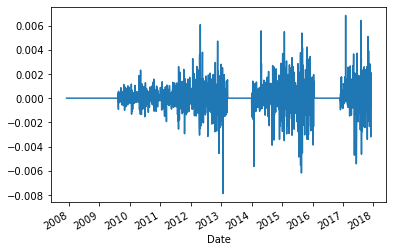

In [36]:
equity_curve['returns'].plot()